# Style Transfer
In this, we use VGG19 pretrained model to change the image into different style of another image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
# Load vgg model features and freeze the parameters
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
# Function to load the image and get the tensor form of the image
def load_image(img_url, max_size=400, shape=None):
    response = requests.get(img_url, stream=True)
    # Open the image and convert to RGB format
    image = Image.open(response.raw).convert('RGB')
    # Find the max size of the image
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    # Use the shape to define the size
    if shape is not None:
        size = shape

    # Apply Image transformations to resize, convert to tensor and normalize the RGB values
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    image = in_transform(image).unsqueeze(0)
    return image

# Convert image from tensor to numpy array for plotting
def im_convert(tensor):
    # Copy tensor and convert to numpy
    image = tensor.clone().detach().numpy()
    image = image.squeeze()
    # Change 1x28x28 dimensions to 28x28x1
    image = image.transpose(1, 2, 0)
    # De-normalize the image using the same mean and std
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    # To make sure the range of image pixels is between 0 and 1
    image = image.clip(0, 1)
    return image

In [5]:
city = 'https://i.pinimg.com/originals/c8/c1/c2/c8c1c280c31526a7b5ee471d82ff606e.jpg'
starry_night = 'https://images.wallpaperscraft.com/image/vincent_van_gogh_the_starry_night_oil_canvas_117815_1440x900.jpg'
content = load_image(city).to(device)
print(content.shape)
# Use the content shape to adjust the shape of style
style = load_image(starry_night, shape=content.shape[-2:]).to(device)

torch.Size([1, 3, 400, 640])


(-0.5, 639.5, 399.5, -0.5)

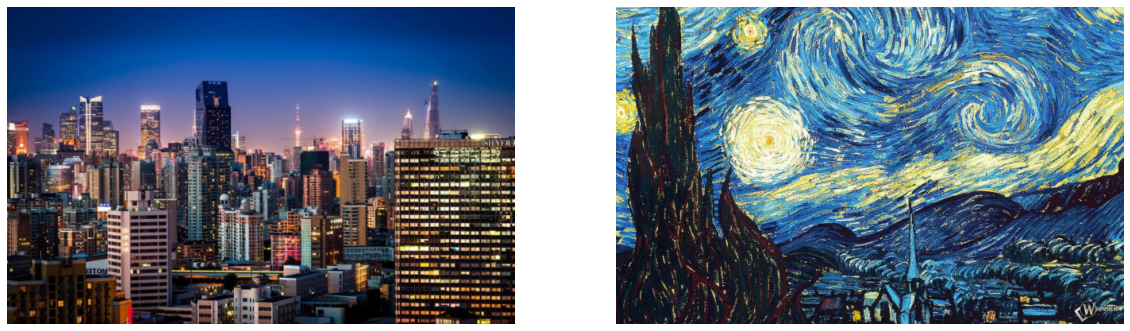

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [11]:
# Extract features from the model
def get_features(image, model):
    # The layers we want to extract are the first convolutional layer of each conv, pool batch
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
             '10': 'conv3_1',
             '19': 'conv4_1',
             '21': 'conv4_2', # content extraction
             '28': 'conv5_1'}
    # Extract features
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    return features

# Get the Gram Matrix
def gram_matrix(tensor):
    # Get batch size, depth, height, width
    b, d, h, w = tensor.size()
    # Convert to two dimensional tensor
    tensor = tensor.view(d, h*w)
    # Calculate Multiplication of two tensors T and T_transpose
    gram = torch.mm(tensor, tensor.t())
    return gram

In [12]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Get the Gram Matrix for each style feature
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
# Define weights for each style layer, ignoring conv4_2
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1 # alpha
style_weight = 1e6 # beta

In [13]:
target = content.clone().requires_grad_(True)
target.to(device)

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.7020, -0.7020, -0.6941,  ..., -0.8588, -0.8588, -0.8588],
          [-0.7098, -0.7098, -0.7020,  ..., -0.8745, -0.8824, -0.8667],
          [-0.7255, -0.7333, -0.7333,  ..., -0.8667, -0.8745, -0.8667]],

         [[-0.7647, -0.7647, -0.7647,  ..., -0.7569, -0.7569, -0.7569],
          [-0.7647, -0.7647, -0.7647,  ..., -0.7569, -0.7569, -0.7569],
          [-0.7647, -0.7647, -0.7647,  ..., -0.7569, -0.7569, -0.7569],
          ...,
          [-0.8039, -0.8039, -0.7961,  ..., -0.9686, -0.9529, -0.9294],
          [-0.8118, -0.8118, -0.8039,  ..., -0.9843, -0.9843, -0.9686],
          [-0.8275, -0.8353, -0.8353,  ..., -0.9765, -0.9843, -0.9765]],

         [[-0.3412, -0.3412, -0.3412,  ..., -0.3098, -0.3098, -0.3098],
          [-0.3412, -0.3412, -

In [14]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100

# Get the target image shape
height, width, channels = im_convert(target).shape
# Initialize empty array to save 300 images
image_array = np.empty(shape=(300, height, width, channels))
# Calculate the numeber of steps for each image to capture
capture_frame = steps/300
# Initialize counter
counter = 0

In [ ]:
# Identify the features for each step
for i in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % show_every == 0:
        print('Iteration', i)
        print('Total Loss:', total_loss.item())
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()

    if i % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter += 1

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [ ]:
# Export Video of target image transformations
import cv2
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('style_transfer.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_height, frame_width))
for i in range(300):
    img = image_array[i]
    # Convert normalized pixel value to RGB value and pixel type to uint8
    img = np.array(img * 255, dtype=np.uint8)
    # Convert color format from BGR to RGB
    img = cv2.cvtCOLOR(img, cv2.COLOR_BGR2RGB)
    vid.write(img)
vid.release()